In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
#read in the raw data from just 2023 so there are no shifts
from google.colab import drive
drive.mount('/drive')

raw23= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

Mounted at /drive


In [3]:
#we only want balls in play with non-null measurements
all_data = pd.concat((raw23, raw21))
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

In [4]:
#outcomes
all_data['outcome'] = -1
all_data.loc[all_data.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 'sac_bunt',
                                               'sac_fly_double_play']), 'outcome'] = 0 # in play out
all_data.loc[all_data.events == 'single', 'outcome'] = 1 #single
all_data.loc[all_data.events == 'double', 'outcome'] = 2 # double
all_data.loc[all_data.events == 'triple', 'outcome'] = 3 #triple
all_data.loc[all_data.events == 'home_run', 'outcome'] = 4 #hr

In [5]:
#remove non hits
all_data = all_data.loc[all_data.outcome > 0]
all_data.outcome = all_data.outcome - 1

In [6]:
#train test split
train, test = train_test_split(all_data, train_size = 0.7)

In [7]:
#model
mod = HistGradientBoostingClassifier().fit(train[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values, train.outcome.values)

In [8]:
#calibration
def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

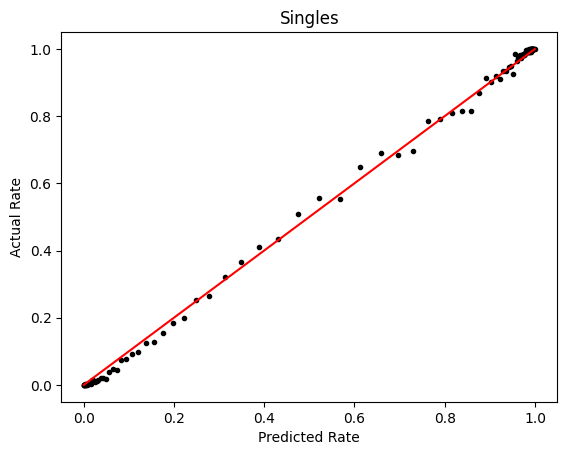

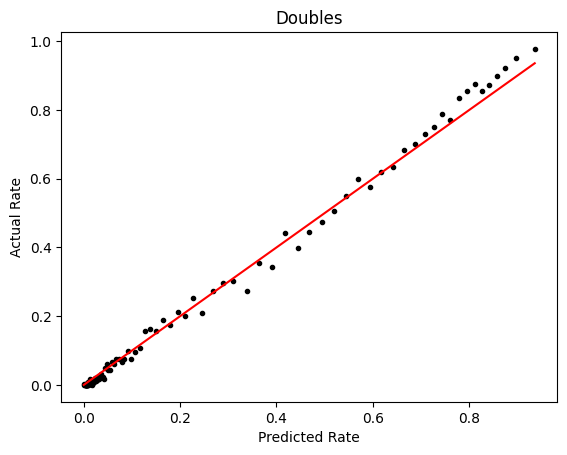

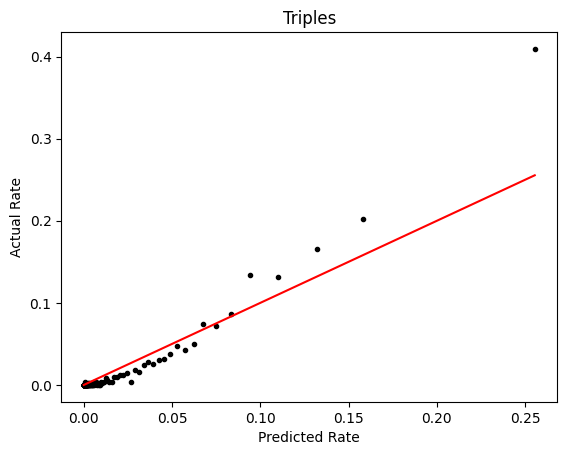

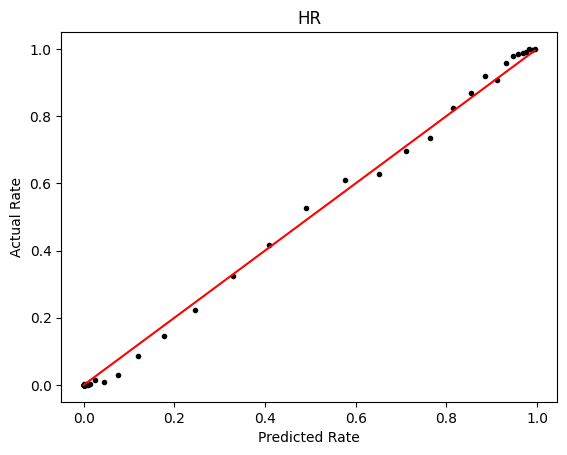

In [9]:
p1 = mod.predict_proba(train[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
calibration(p1[:,0], (train.outcome.values == 0).astype(int), 500, 'Singles')
plt.show()
calibration(p1[:,1], (train.outcome.values == 1).astype(int), 500, 'Doubles')
plt.show()
calibration(p1[:,2], (train.outcome.values == 2).astype(int), 500, 'Triples')
plt.show()
calibration(p1[:,3], (train.outcome.values == 3).astype(int), 500, 'HR')
plt.show()

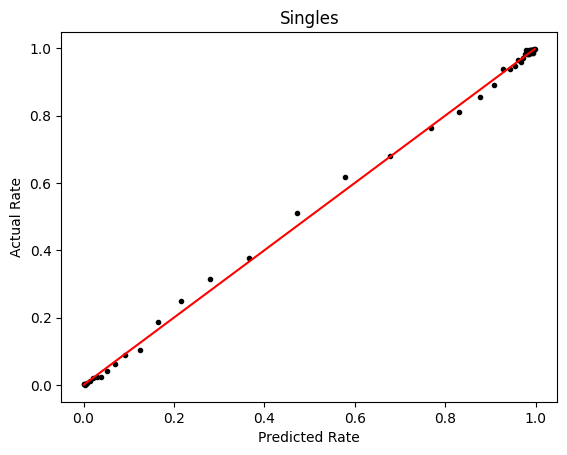

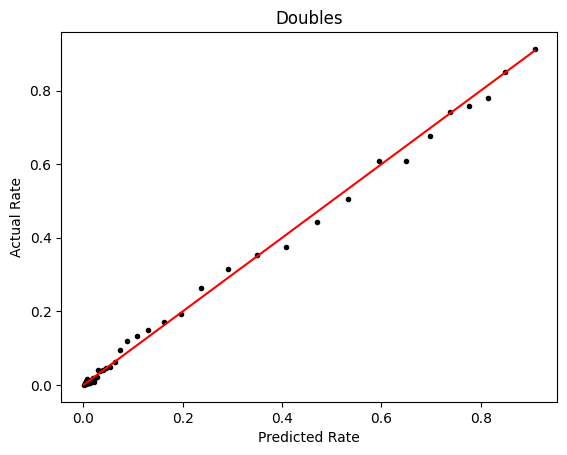

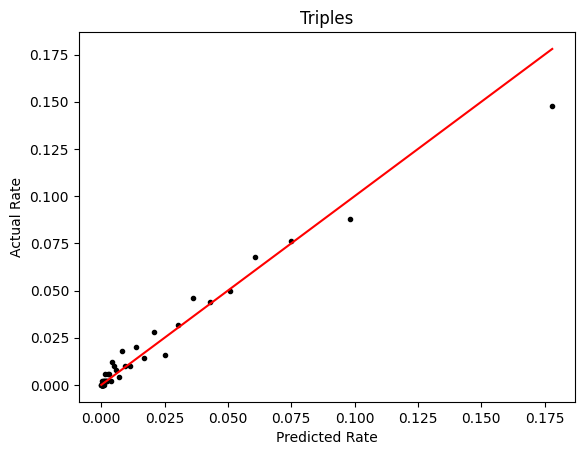

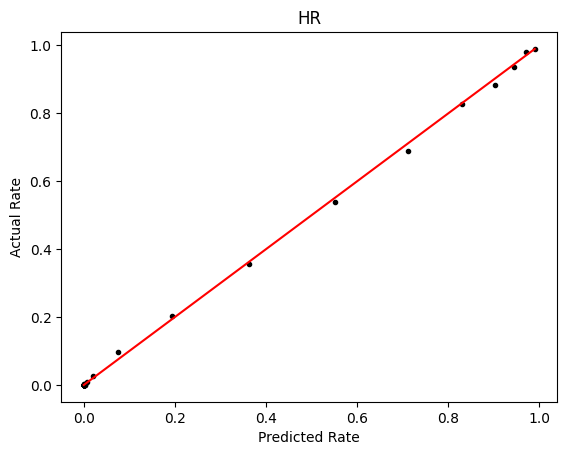

In [10]:
p2 = mod.predict_proba(test[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
calibration(p2[:,0], (test.outcome.values == 0).astype(int), 500, 'Singles')
plt.show()
calibration(p2[:,1], (test.outcome.values == 1).astype(int), 500, 'Doubles')
plt.show()
calibration(p2[:,2], (test.outcome.values == 2).astype(int), 500, 'Triples')
plt.show()
calibration(p2[:,3], (test.outcome.values == 3).astype(int), 500, 'HR')
plt.show()

In [11]:
#looks good enough. Train the final model
mod = HistGradientBoostingClassifier().fit(all_data[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values, all_data.outcome.values)

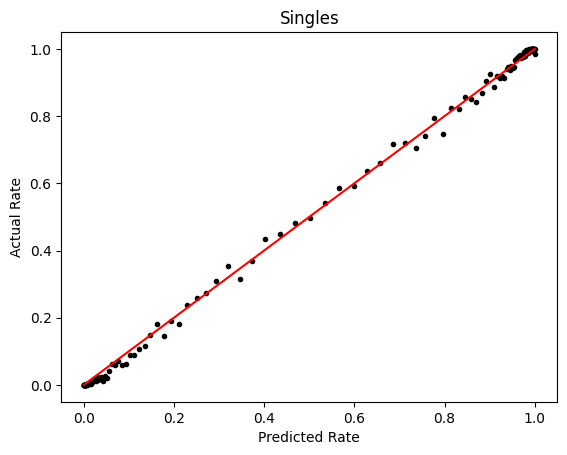

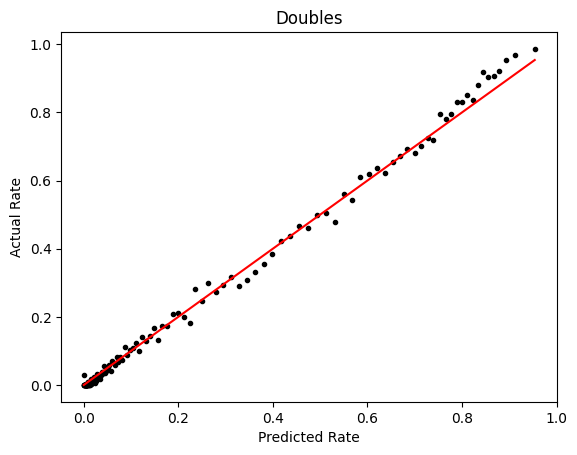

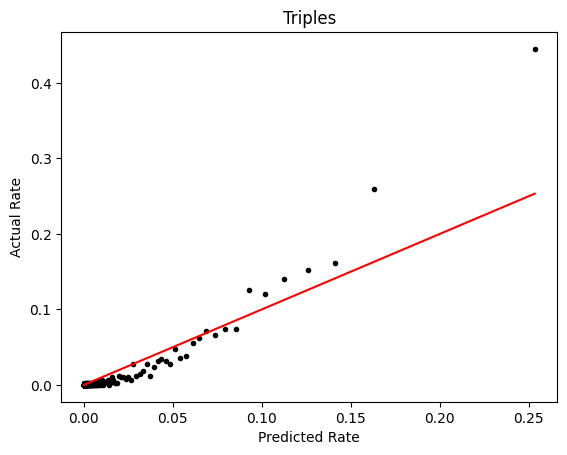

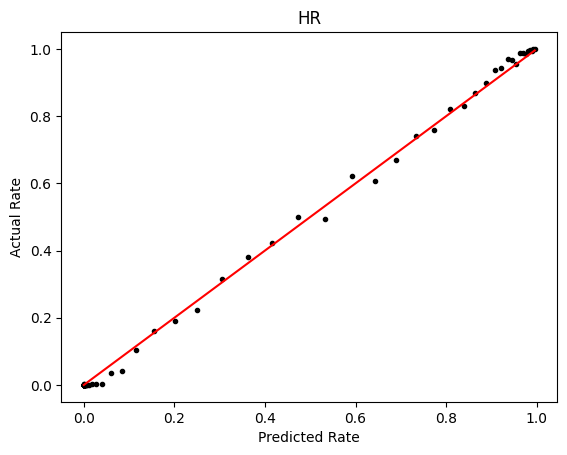

In [12]:
p3 = mod.predict_proba(all_data[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
calibration(p3[:,0], (all_data.outcome.values == 0).astype(int), 500, 'Singles')
plt.show()
calibration(p3[:,1], (all_data.outcome.values == 1).astype(int), 500, 'Doubles')
plt.show()
calibration(p3[:,2], (all_data.outcome.values == 2).astype(int), 500, 'Triples')
plt.show()
calibration(p3[:,3], (all_data.outcome.values == 3).astype(int), 500, 'HR')
plt.show()

In [14]:
import pickle
with open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/xwoba_model.pkl', 'wb') as f:
  pickle.dump(mod, f)